# DataCamp Certification Case Study

### Project Brief

Congratulations, you have just landed your first job as a data scientist at Nearly New Nautical! Nearly New Nautical is a website that allows users to advertise their used boats for sale. To boost traffic to the website, the product manager wants to prevent listing boats that do not receive many views. 

The product manager wants to know if you can develop a model to predict the number of views a listing will receive based on the boat's features. She would consider using your model if, on average, the predictions were only 50% off of the true number of views a listing would receive.

In addition, she has noticed that many users never complete the introductory survey to list their boat. She suspects that it is too long and has asked you whether some features are more predictive of views than others. If so, she may be able to trim the length of the survey and increase the number of people who sign up.

You will need to present your findings in two formats:
- First, you will need to present your findings to the product manager via a 10 minute oral presentation. The owner has no technical data science background. 
- You will also need to submit a technical report to your manager, who does have a strong technical data science background.

The data you will use for this analysis can be accessed here: `"data/boat_data.csv"`

## Importing

In [52]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_percentage_error, r2_score
from sklearn.impute import SimpleImputer

## Loading the Data

In [2]:
df = pd.read_csv("data/boat_data.csv")

In [3]:
df.head()

,Price,Boat Type,Manufacturer,Type,Year Built,Length,Width,Material,Location,Number of views last 7 days
0,CHF 3337,Motor Yacht,Rigiflex power boats,new boat from stock,2017,4.00,1.90,NaN,Switzerland Â» Lake Geneva Â» VÃ©senaz,226
1,EUR 3490,Center console boat,Terhi power boats,new boat from stock,2020,4.00,1.50,Thermoplastic,Germany Â» BÃ¶nningstedt,75
2,CHF 3770,Sport Boat,Marine power boats,new boat from stock,0,3.69,1.42,Aluminium,Switzerland Â» Lake of Zurich Â» StÃ¤fa ZH,124
3,DKK 25900,Sport Boat,Pioner power boats,new boat from stock,2020,3.00,1.00,NaN,Denmark Â» Svendborg,64
4,EUR 3399,Fishing Boat,Linder power boats,new boat from stock,2019,3.55,1.46,Aluminium,Germany Â» Bayern Â» MÃ¼nchen,58


## Understanding the data

In [4]:
#Let's take a look at the shape of the df
df.shape

(9888, 10)

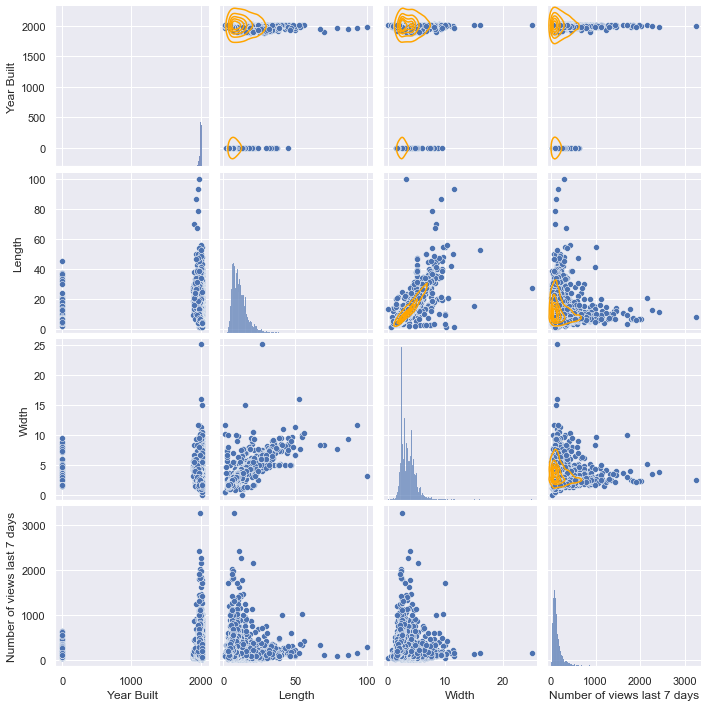

In [5]:
sns.set()
g = sns.pairplot(df)
g.map_upper(sns.kdeplot, n_levels=6, color='orange')
plt.show()

If we take a look at the above pairplot it seems like the shorter the length of the boat is the more views it got(if it's way small it got less views), which is quite intuitive since smaller boats tend to be cheaper. Same story with the width as well(As they are obviously possitively correlated.)

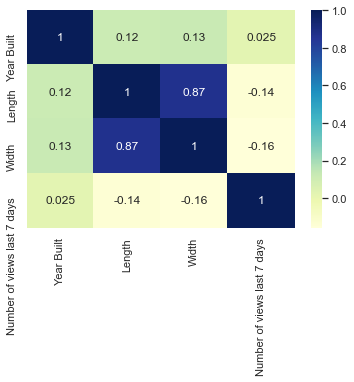

In [6]:
corr = df.corr()
sns.heatmap(corr, cmap="YlGnBu", annot=True)
plt.show()

In [7]:
df.rename(columns={'Number of views last 7 days' : 'views'}, inplace=True) #renaming the column name as it is too long

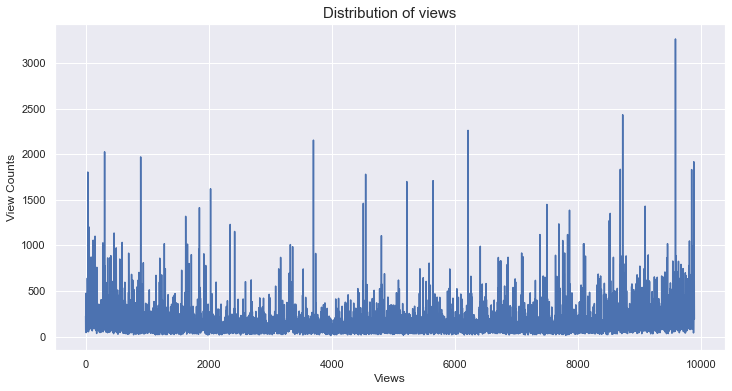

In [54]:
#target variable
fig = plt.figure(figsize=(12,6))
df['views'].plot()
plt.xlabel("Views")
plt.ylabel("View Counts")
plt.title("Distribution of views", size=15)
plt.show()

## Feature Engineering

In [9]:
#The price column should be a int type so let's convert it into int
df['Currency'] = df.loc[:,'Price'].str.slice(0,3)
df['Price'] = df['Price'].str.replace(r'[A-Z\D\W]', '').astype('int')

In [10]:
df.Currency.unique()

array(['CHF', 'EUR', 'DKK', 'Â£ '], dtype=object)

In [11]:
df.head(20)

,Price,Boat Type,Manufacturer,Type,Year Built,Length,Width,Material,Location,views,Currency
0,3337,Motor Yacht,Rigiflex power boats,new boat from stock,2017,4.00,1.90,NaN,Switzerland Â» Lake Geneva Â» VÃ©senaz,226,CHF
1,3490,Center console boat,Terhi power boats,new boat from stock,2020,4.00,1.50,Thermoplastic,Germany Â» BÃ¶nningstedt,75,EUR
2,3770,Sport Boat,Marine power boats,new boat from stock,0,3.69,1.42,Aluminium,Switzerland Â» Lake of Zurich Â» StÃ¤fa ZH,124,CHF
3,25900,Sport Boat,Pioner power boats,new boat from stock,2020,3.00,1.00,NaN,Denmark Â» Svendborg,64,DKK
4,3399,Fishing Boat,Linder power boats,new boat from stock,2019,3.55,1.46,Aluminium,Germany Â» Bayern Â» MÃ¼nchen,58,EUR
5,3650,Sport Boat,Linder power boats,new boat from stock,0,4.03,1.56,Aluminium,Switzerland Â» Lake Constance Â» Uttwil,132,CHF
6,3600,Catamaran,NaN,"Used boat,Unleaded",1999,6.20,2.38,Aluminium,Switzerland Â» Neuenburgersee Â» Yvonand,474,CHF
7,24800,Sport Boat,NaN,Used boat,0,3.00,NaN,NaN,Denmark Â» Svendborg,134,DKK
8,3333,Fishing Boat,Crescent power boats,new boat from stock,2019,3.64,1.37,NaN,Germany Â» Bayern Â» Boote+service Oberbayern,45,EUR
9,3300,Pontoon Boat,Whaly power boats,new boat from stock,2018,4.35,1.73,NaN,Italy Â» Dormelletto,180,EUR


In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9888 entries, 0 to 9887
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Price         9888 non-null   int64  
 1   Boat Type     9888 non-null   object 
 2   Manufacturer  8550 non-null   object 
 3   Type          9882 non-null   object 
 4   Year Built    9888 non-null   int64  
 5   Length        9879 non-null   float64
 6   Width         9832 non-null   float64
 7   Material      8139 non-null   object 
 8   Location      9852 non-null   object 
 9   views         9888 non-null   int64  
 10  Currency      9888 non-null   object 
dtypes: float64(2), int64(3), object(6)
memory usage: 849.9+ KB


Before we encode the categorical columns let's remove the NaN values

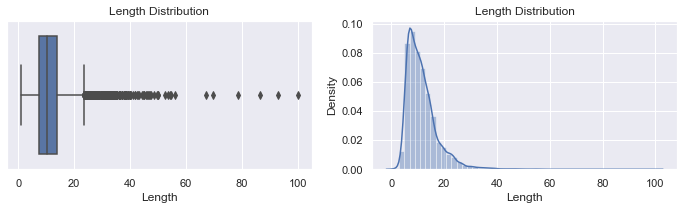

In [13]:
#First let's take a look at the length and the width columns
fig = plt.figure(figsize=(12,6))
ax1 = fig.add_subplot(223)
sns.boxplot(df.Length)
ax1.set_title("Length Distribution")
ax2 = fig.add_subplot(224)
sns.distplot(df.Length)
ax2.set_title("Length Distribution")
plt.savefig('heightDistributions.png')

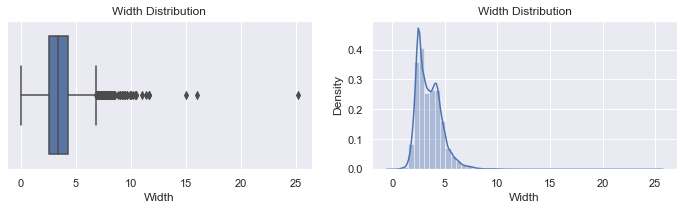

In [14]:
fig = plt.figure(figsize=(12,6))
ax1 = fig.add_subplot(223)
sns.boxplot(df.Width)
ax1.set_title("Width Distribution")
ax2 = fig.add_subplot(224)
sns.distplot(df.Width)
ax2.set_title("Width Distribution")
plt.savefig('weightDistributions.png')

In [15]:
df['Length'].fillna(int(df['Length'].median()), inplace=True)

In [16]:
df['Width'].fillna(int(df['Width'].median()), inplace=True)

In [17]:
df.drop(['Location'], axis=1, inplace=True)

In [18]:
#If you notice there are 0 for the year built in some cases so let's drop them as well
df = df[df['Year Built'] != 0]

In [19]:
freq_imp = SimpleImputer(strategy='most_frequent')
for col in ['Manufacturer', 'Type', 'Material']:
    df[[col]] = freq_imp.fit_transform(df[[col]])

Let us take a look at the data now

In [20]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9337 entries, 0 to 9887
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Price         9337 non-null   int64  
 1   Boat Type     9337 non-null   object 
 2   Manufacturer  9337 non-null   object 
 3   Type          9337 non-null   object 
 4   Year Built    9337 non-null   int64  
 5   Length        9337 non-null   float64
 6   Width         9337 non-null   float64
 7   Material      9337 non-null   object 
 8   views         9337 non-null   int64  
 9   Currency      9337 non-null   object 
dtypes: float64(2), int64(3), object(5)
memory usage: 802.4+ KB


#### Label Encoding the categorical variables

In [21]:
le = LabelEncoder()
for col in ['Boat Type', 'Manufacturer', 'Type', 'Material', 'Currency']:
    df[[col]] = le.fit_transform(df[[col]])

In [22]:
df.head()

,Price,Boat Type,Manufacturer,Type,Year Built,Length,Width,Material,views,Currency
0,3337,95,640,15,2017,4.00,1.90,2,226,0
1,3490,38,778,15,2020,4.00,1.50,9,75,2
3,25900,115,594,15,2020,3.00,1.00,2,64,1
4,3399,72,445,15,2019,3.55,1.46,0,58,2
6,3600,37,154,14,1999,6.20,2.38,0,474,0


In [23]:
df.shape

(9337, 10)

Now that we encoded the data let's split it into training and testing data.

### Creating the train and test set

In [24]:
X = df.drop(['Price'], axis=1)
y = df['Price']

In [25]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [26]:
X_train.shape

(7469, 9)

In [27]:
y_train.shape

(7469,)

In [28]:
X_test.shape

(1868, 9)

In [29]:
y_test.shape

(1868,)

## Modelling

In [44]:
#Let's use RandomForestRegressor and RandomizedSearchCV

param = [
    {'n_estimators': [100, 200, 300, 400, 450, 500], 
     'max_depth': [3, 4, 6, 8, 10, 12,], 
     'max_leaf_nodes': [15, 20, 25,30]}, 
]

rf = RandomForestRegressor(random_state=42)
rs_rf = RandomizedSearchCV(rf, param, cv = 5, n_jobs = -1, verbose = 1)
rs_rf.fit(X_train, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


RandomizedSearchCV(cv=5, estimator=RandomForestRegressor(random_state=42),
                   n_jobs=-1,
                   param_distributions=[{'max_depth': [3, 4, 6, 8, 10, 12],
                                         'max_leaf_nodes': [15, 20, 25, 30],
                                         'n_estimators': [100, 200, 300, 400,
                                                          450, 500]}],
                   verbose=1)

In [45]:
rf_best = rs_rf.best_estimator_
rf_best

RandomForestRegressor(max_depth=8, max_leaf_nodes=30, n_estimators=450,
                      random_state=42)

## Evaluating

In [46]:
rs_rf.score(X_test, y_test)

0.7810895373640719

In [47]:
y_pred = rs_rf.predict(X_test)

In [53]:
print(r2_score(y_test,y_pred))

0.7810895373640719


Our model is able to tell 78% of the data